# Examples 

Below are some examples of how the package could be used in astronomical studies. While there are more use cases, the most common are outlined below.

## Examine an object

Let's start with the first example. Let one wants to identify all three-body and two-body resonances of an asteroid. One has to perform the following steps:

1. set up the model, including planets and their initial conditions;
2. add an object (or objects), which is examined;
3. find possible resonances, in which the object can be trapped in;
4. integrate the differential equations of motion for a long period of time (usually, $\approx 10^5$ yrs);
5. identify the resonant status of the object based on the analysis of the resonant angle, semi-major axis, and other variables.

Without loss of generality, let's examine the following case:

1. The target object is the asteroid 463 Lola.
2. The planets are Jupiter and Saturn for both, three-body and two-body cases.

Let's start with setting up the model.

In [26]:
import resonances
from resonances.data.astdys import astdys
from resonances.matrix.three_body_matrix import ThreeBodyMatrix
from resonances.matrix.two_body_matrix import TwoBodyMatrix

For this task, we need the package, AstDyS component for the initial data of the asteroid, and Matrixes components for finding the possible resonances.

Now, let's find the initial data of an asteroid and set the planets.

In [27]:
elem = astdys.search('463')
planets = ['Jupiter', 'Saturn']

We will work within the Solar system. Hence, we can use NASA JPL data for planets, which are supported by the package automatically.

In [28]:
sim = resonances.Simulation()
sim.create_solar_system()

Now let's find all possible MMRs based on the closeness of the value of the semi-major axis. Let's also print all MMRs found.

In [29]:
mmrs = ThreeBodyMatrix.find_resonances(elem['a'], planets=planets)
mmrs2 = TwoBodyMatrix.find_resonances(elem['a'], planets=planets)
mmrs = mmrs + mmrs2
for mmr in mmrs:
    sim.add_body('463', mmr, name='463 (Lola), resonance={}'.format(mmr.to_short()))
    print(mmr.to_short())

2J+3S-1
4J-2S-1
6J-7S-1
6J+1S-2
8S-1
8S+1


It seems that there are several resonances, in which Lola can be trapped. Let's now dynamically check whether it is in one of these resonances.

There are two ways of performing that. Firstly, we can plot the resonant angles and the periodograms of these angles and semi-major axis and determine visually whether or not the asteroid is trapped in the resonance. Secondly, we can get the data from the simulation and check the column 'status'. For all available statuses, please refer to the [Libration](../libration) section.

Let's start with the plots.

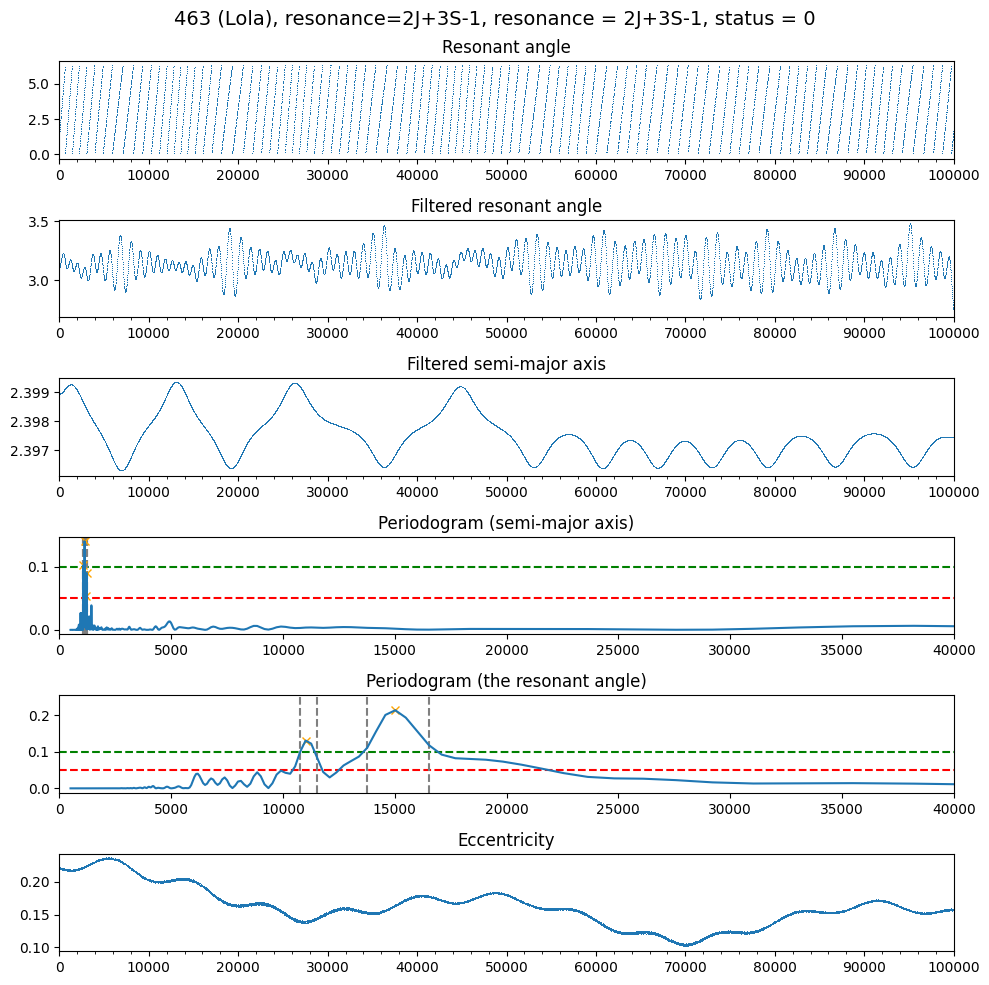

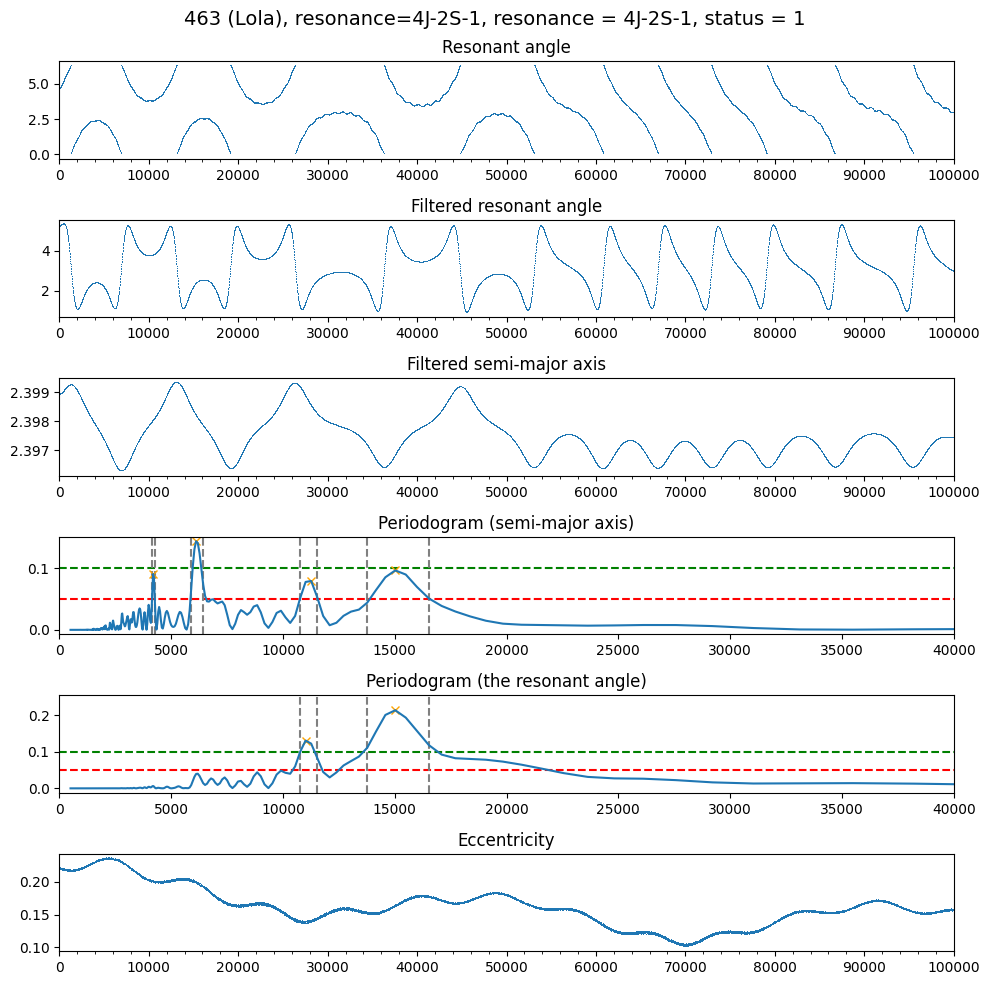

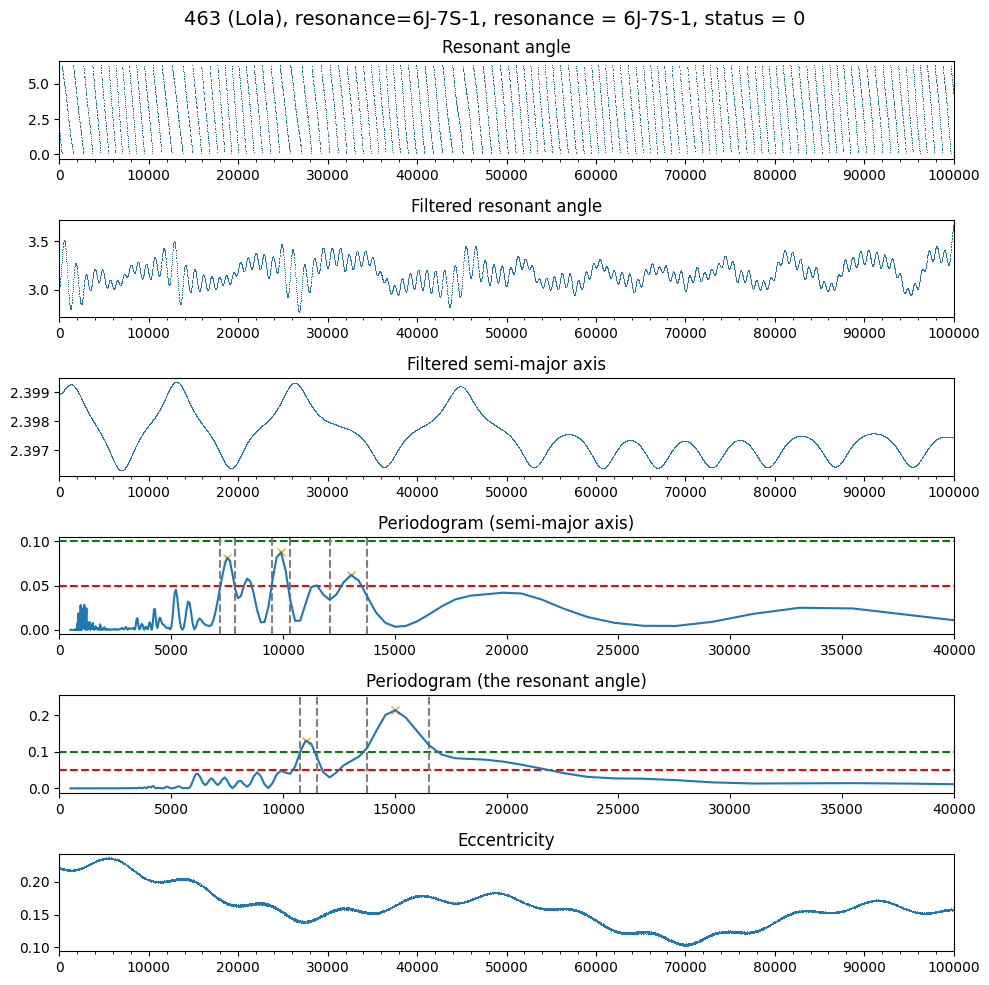

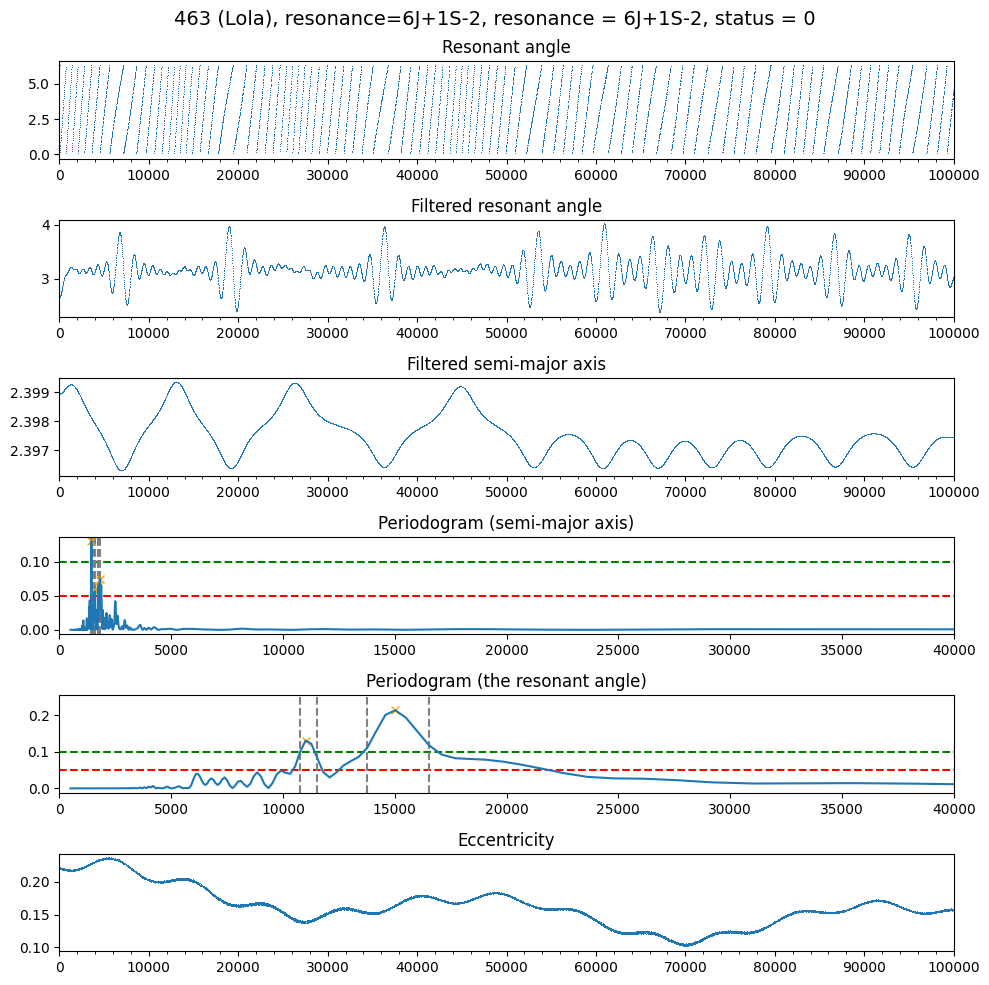

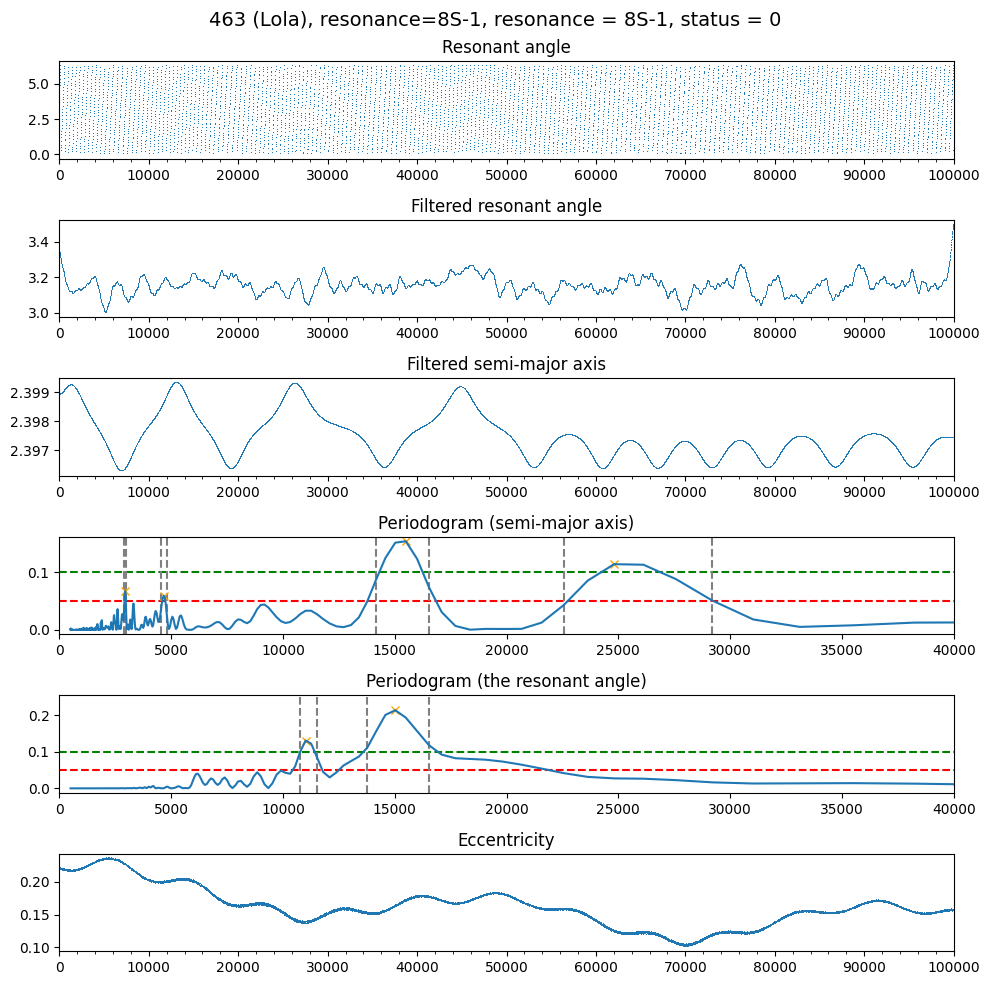

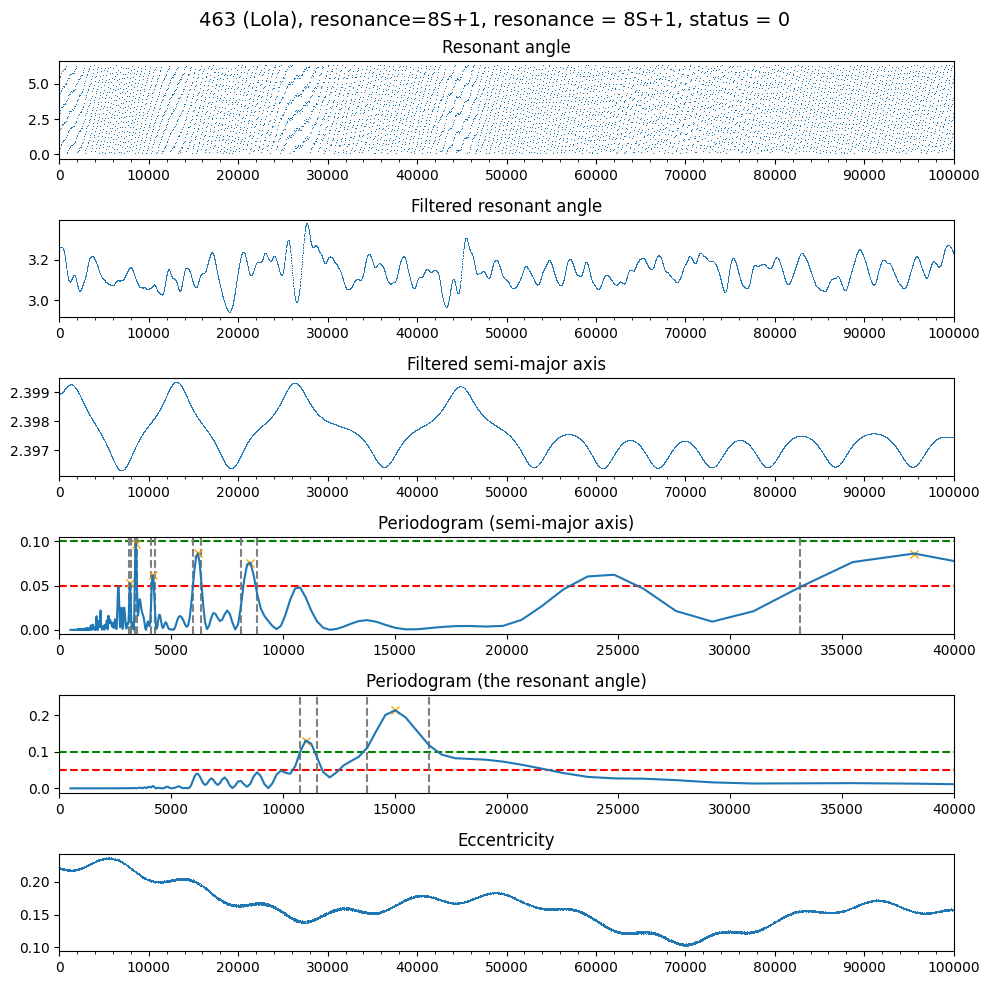

In [30]:
sim.dt = 1 # for speed purposes.
sim.plot = 'show'
sim.run()

From the plots, it is clear that only `4J-2S-1` is the only resonance, in which Lola is trapped in. Let's double-check this with the actual values.

In [31]:
df_summary = sim.get_simulation_summary()
df_summary.head(10)

,name,status,pure,num_libration_periods,max_libration_length,monotony,overlapping,a,e,inc,Omega,omega,M
0,"463 (Lola), resonance=2J+3S-1",0,False,99,1416.747317,0.014645,,2.398473,0.220093,0.236345,0.636907,5.753529,6.136003
1,"463 (Lola), resonance=4J-2S-1",1,False,7,60840.542098,0.659822,"(10774, 11526), (13771, 16529)",2.398473,0.220093,0.236345,0.636907,5.753529,6.136003
2,"463 (Lola), resonance=6J-7S-1",0,False,112,1528.176882,0.997771,,2.398473,0.220093,0.236345,0.636907,5.753529,6.136003
3,"463 (Lola), resonance=6J+1S-2",0,False,93,1719.198992,0.035817,,2.398473,0.220093,0.236345,0.636907,5.753529,6.136003
4,"463 (Lola), resonance=8S-1",0,False,205,588.984840,0.005571,"(14165, 16529)",2.398473,0.220093,0.236345,0.636907,5.753529,6.136003
5,"463 (Lola), resonance=8S+1",0,False,2466,79.592546,1.000000,,2.398473,0.220093,0.236345,0.636907,5.753529,6.136003


Based on the dataframe, the only non-zero status is for the resonance `4J-2S-1`. The maximum libration length is greater than `60,000` years, which is good.

Therefore, we can claim that the asteroid 463 Lola is trapped in the transient resonance `4J-2S-1`.

## Find resonances within a range

Let's imagine another task. Let one want to find what are the possible two-body mean-motions resonances between `2.3` and `2.4` AU.

In [32]:
mmrs = TwoBodyMatrix.find_resonances(2.35, sigma=0.05, planets=None)
for mmr in mmrs:
    print(mmr.to_short())

1V-6
1V+6
2E-7
2E+7
3E-11
10J-3
8S-1
8S+1


The code above performs the following:

1. `find_resonances` finds resonances within the range $2.35\pm 0.05 = [2.3, 2.4]$.
2. The option `planets` is set to `None`. Hence, the package will check all possible planets. One might specify conrete planets. For example:

In [33]:
mmrs = TwoBodyMatrix.find_resonances(2.35, sigma=0.05, planets=['Jupiter', 'Saturn'])
for mmr in mmrs:
    print(mmr.to_short())

10J-3
8S-1
8S+1


That's it. Now, one can perform any further action with the list of MMRs got. For three-body resonances, the algorithm is the same. The only difference is in the name of the class: `ThreeBodyMatrix` should be used.

## Find all asteroids in the resonance

One might want to examine a concrete resonance. In other words, one might want to find all asteroids that are trapped in this resonance.

Actually, we have two possible options here. We might want to find all asteroids that are close enough to the resonant value of semi-major axis. It does not confirm that they are trapped in the resonance. However, it shows that they **could** be. To confirm that, we have to integrate the orbits of these objects.

Let's start with the first task. To perform this, we need `astdys` component. Let's work with the resonance `6J-3S-2`.

In [34]:
mmr = resonances.create_mmr('6J-3S-2')
df_asteroids = astdys.search_possible_resonant_asteroids(mmr, sigma=0.01)
print('Number of objects found: {}'.format(len(df_asteroids)))
df_asteroids.head(5)

Number of objects found: 4081


,num,a,e,inc,Omega,omega,M
21,22,2.911191,0.098629,0.239111,1.151555,6.244327,1.966840
237,238,2.904920,0.090765,0.216691,3.209084,3.675797,5.019155
306,307,2.906937,0.143875,0.106900,1.761769,5.653935,5.041227
310,311,2.897559,0.005636,0.056270,1.413164,1.385150,6.138759
337,338,2.911153,0.018197,0.105401,5.014468,1.906068,1.041247


There are many candidates. Now let's find whether any of them are resontnat. To perform this, we need a component `finder`. For the example above, I will limit the calculations only by first `10` object to save some time. 

The parameter `dump` specifies how many asteroids should be taken within one iteration. The parameter `max_iterations` specifies how many iterations should be run. If, let's say, `dump=100` and `max_iterations=5`, the `finder` component will examine first $100\cdot 5 = 500$ objects. 

In [35]:
from resonances.experiment import finder

finder.run(resonances.create_mmr('6J-3S-2'), dump=10, max_iterations=1, plot=False)

By default, `finder` saves output data to `cache/finder` subdirectory. Let's check the summary of our simulation.

In [36]:
import pandas as pd
df_finder = pd.read_csv('cache/finder/summary.csv')
df_finder.head(11)

,name,status,pure,num_libration_periods,max_libration_length,monotony,overlapping,a,e,inc,Omega,omega,M
0,16-0,0,False,463,366.125711,0.000000,NaN,2.924145,0.134117,0.054050,2.618532,4.002533,3.557316
1,22-1,0,False,165,939.192042,0.000478,NaN,2.911191,0.098629,0.239111,1.151555,6.244327,1.966840
2,191-2,0,False,229,859.599496,0.982649,NaN,2.894841,0.087664,0.201132,2.778395,3.948814,1.522810
3,208-3,0,False,271,1305.317753,0.963547,"(6434, 6978), (10114, 11014), (24815, 31037)",2.891415,0.010685,0.030452,0.072456,2.238710,5.417237
4,231-4,0,False,461,270.614656,0.000000,NaN,2.924004,0.154555,0.088878,6.116470,4.698223,2.182132
5,238-5,0,False,53,3311.049910,0.833015,NaN,2.904920,0.090765,0.216691,3.209084,3.675797,5.019155
6,277-6,0,False,388,366.125711,0.999522,"(15995, 18369)",2.885866,0.092630,0.020341,4.031522,2.371629,0.540379
7,307-7,0,False,20,8420.891358,0.157434,"(4809, 5054)",2.906937,0.143875,0.106900,1.761769,5.653935,5.041227
8,311-8,0,False,152,891.436514,0.922318,NaN,2.897559,0.005636,0.056270,1.413164,1.385150,6.138759
9,338-9,0,False,132,939.192042,0.168577,NaN,2.911153,0.018197,0.105401,5.014468,1.906068,1.041247


As one might see, the first `10` objects in the example above are false positives (the column `Status` equals `False`).

## Run experiment from a file

To run more complex simulations, one might use a `json` file as an input. Some examples are provided within the package in the directory `docs/examples`: 

1. `asteroids.json` shows how one can test multiple asteroids whether or not they are resonant.
2. `simulation-share.json` provides an example of running a simulation in 6-dimensional space with virtual asteroids.

These `json` files are self-explanatory. The module `loader` is used to load the data. One can easily modify it for one's own needs.

These `json` files are very useful when one generates the list of objects one wants to examine in another software and then wants to evaluate them automatically via `resonances`. Another common use is to run long-time simulations (for days or weeks) on the remote server.

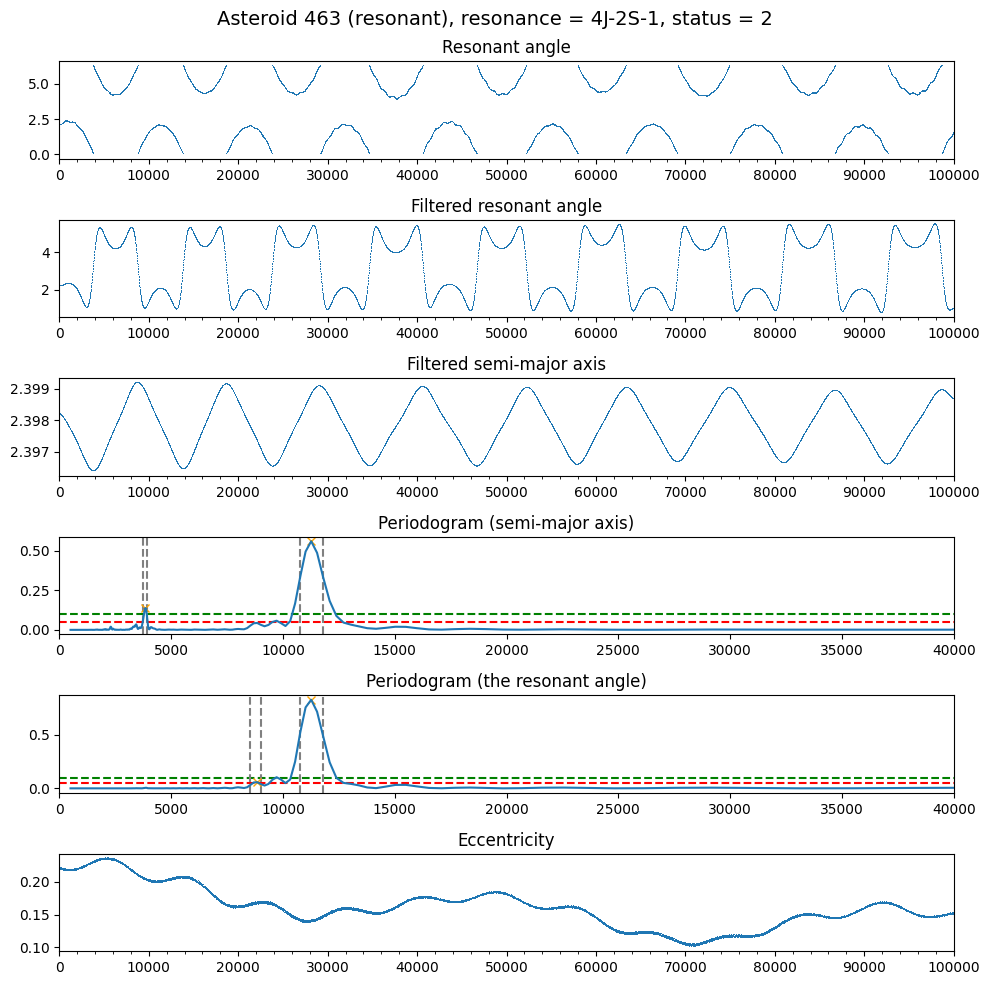

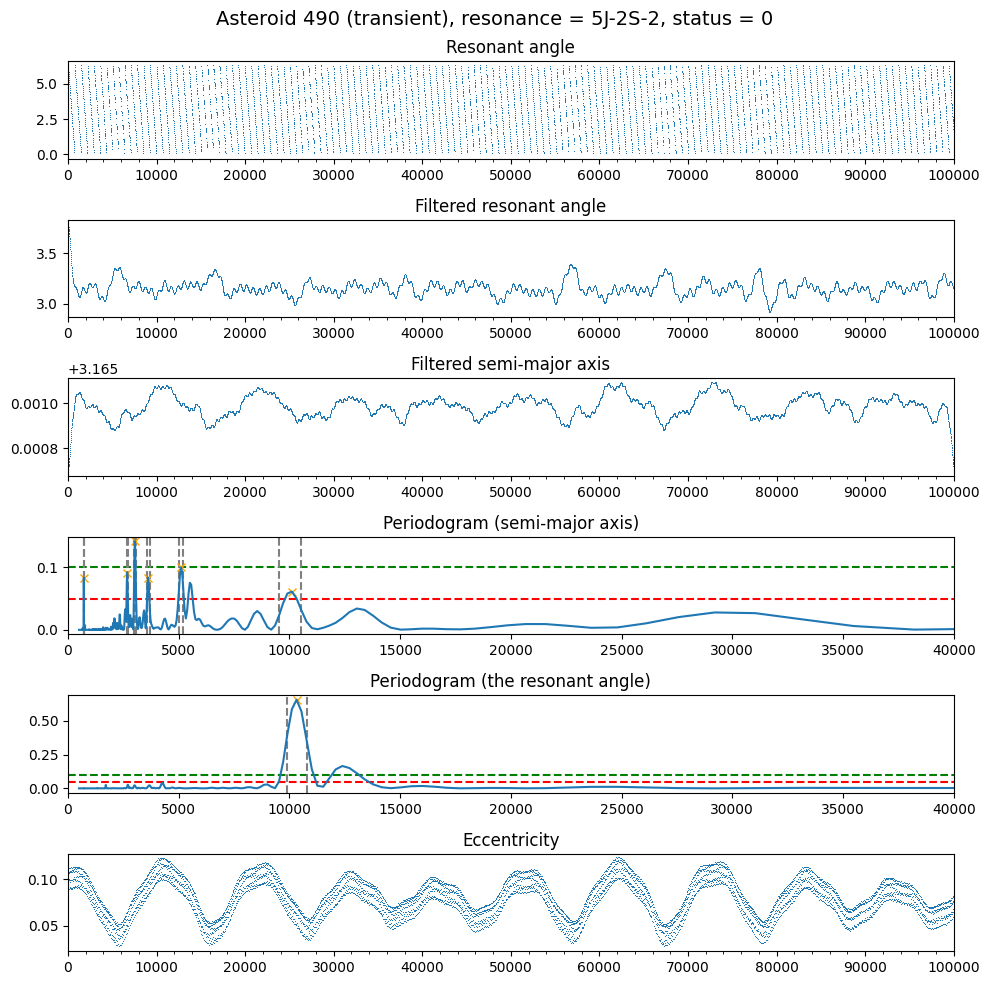

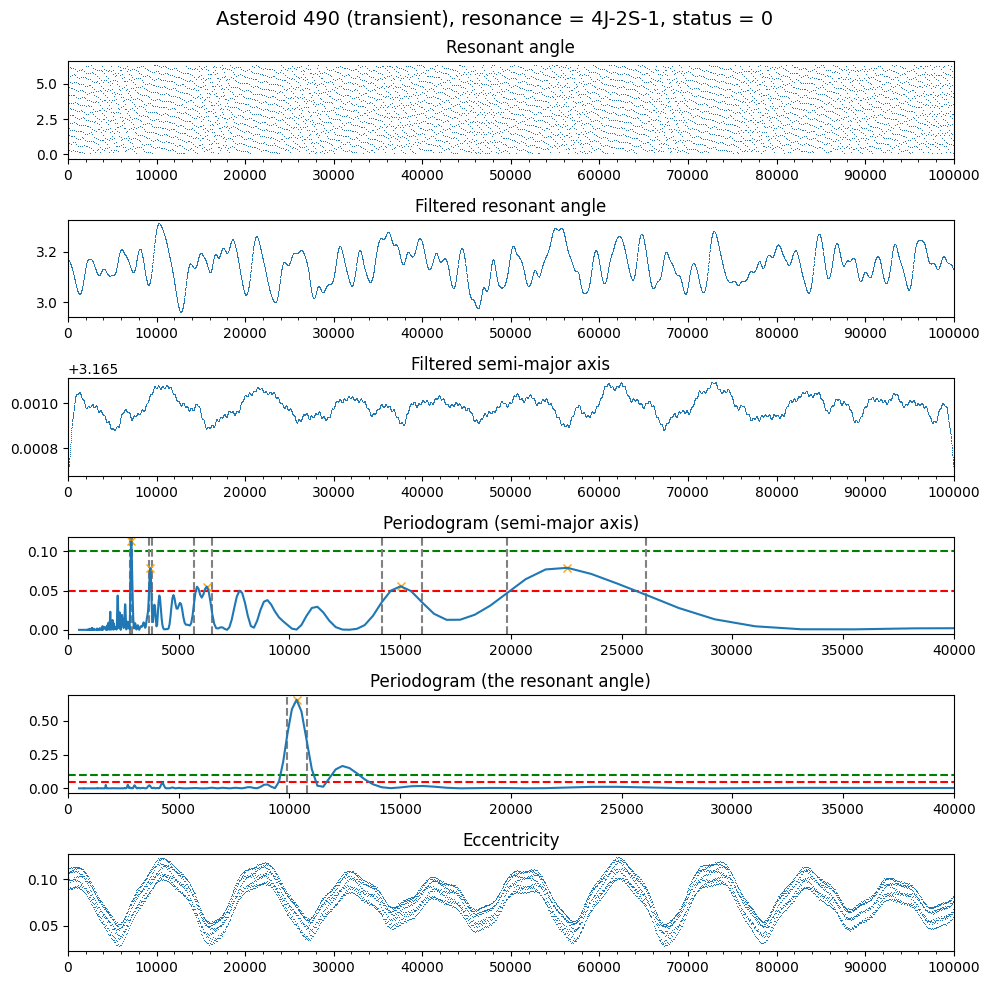

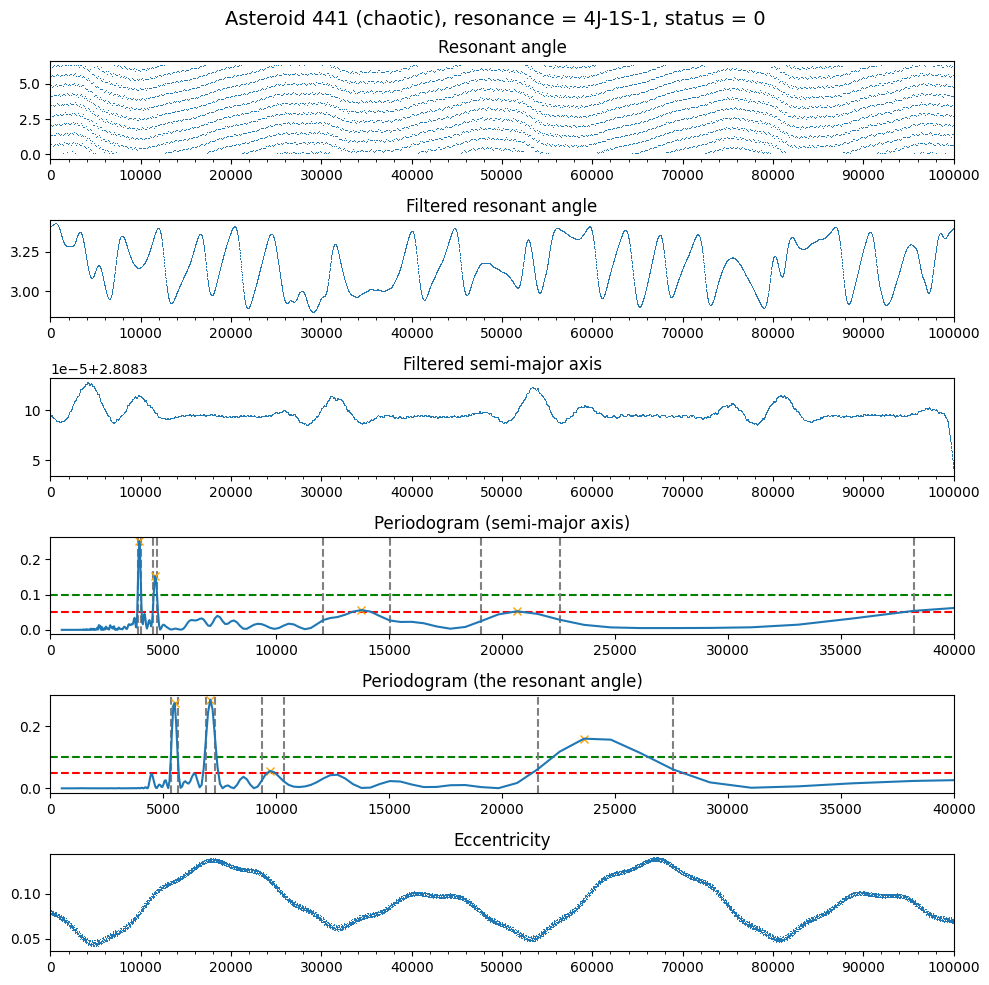

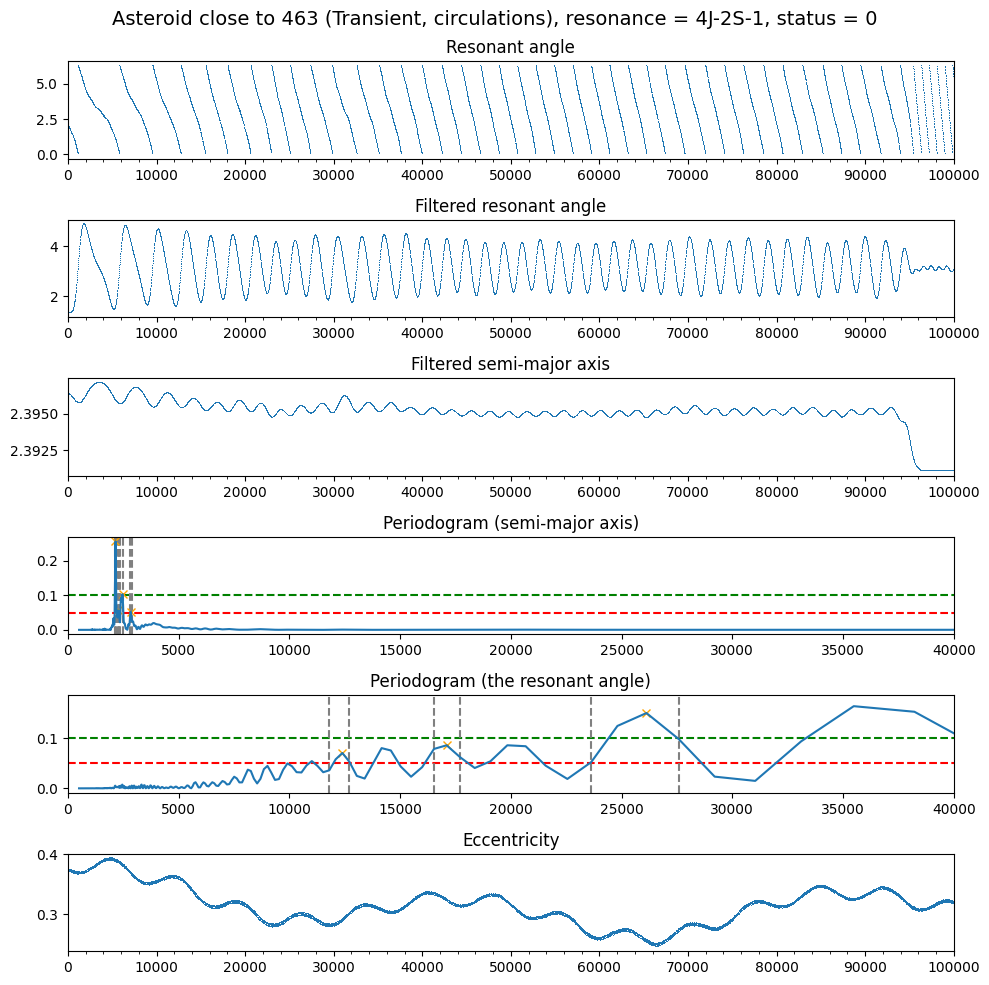

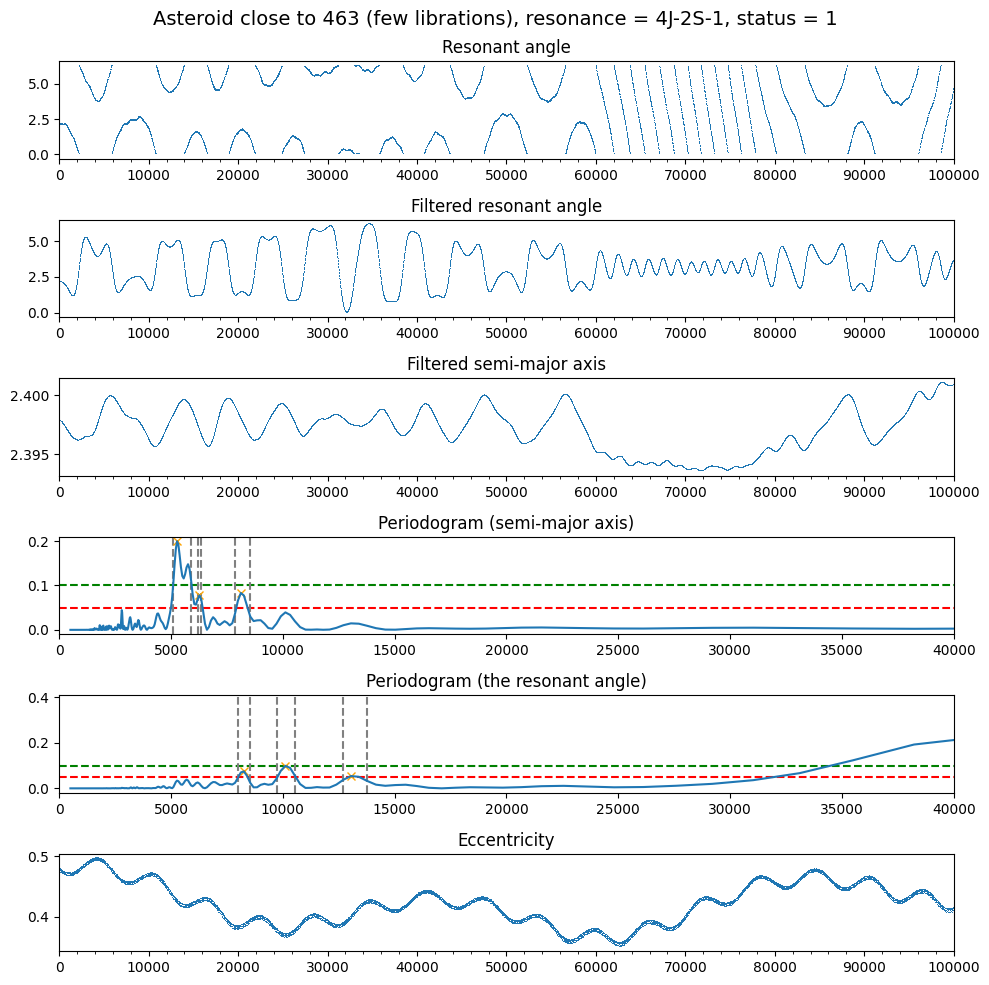

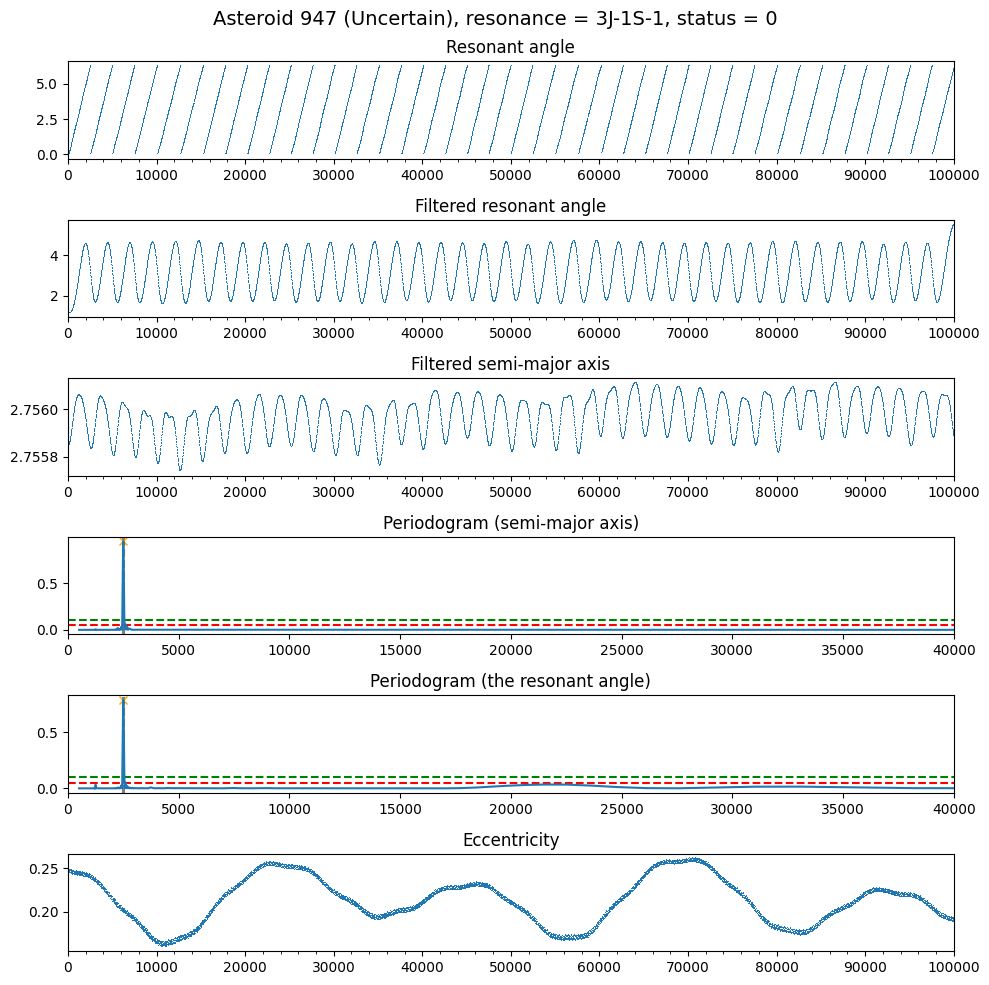

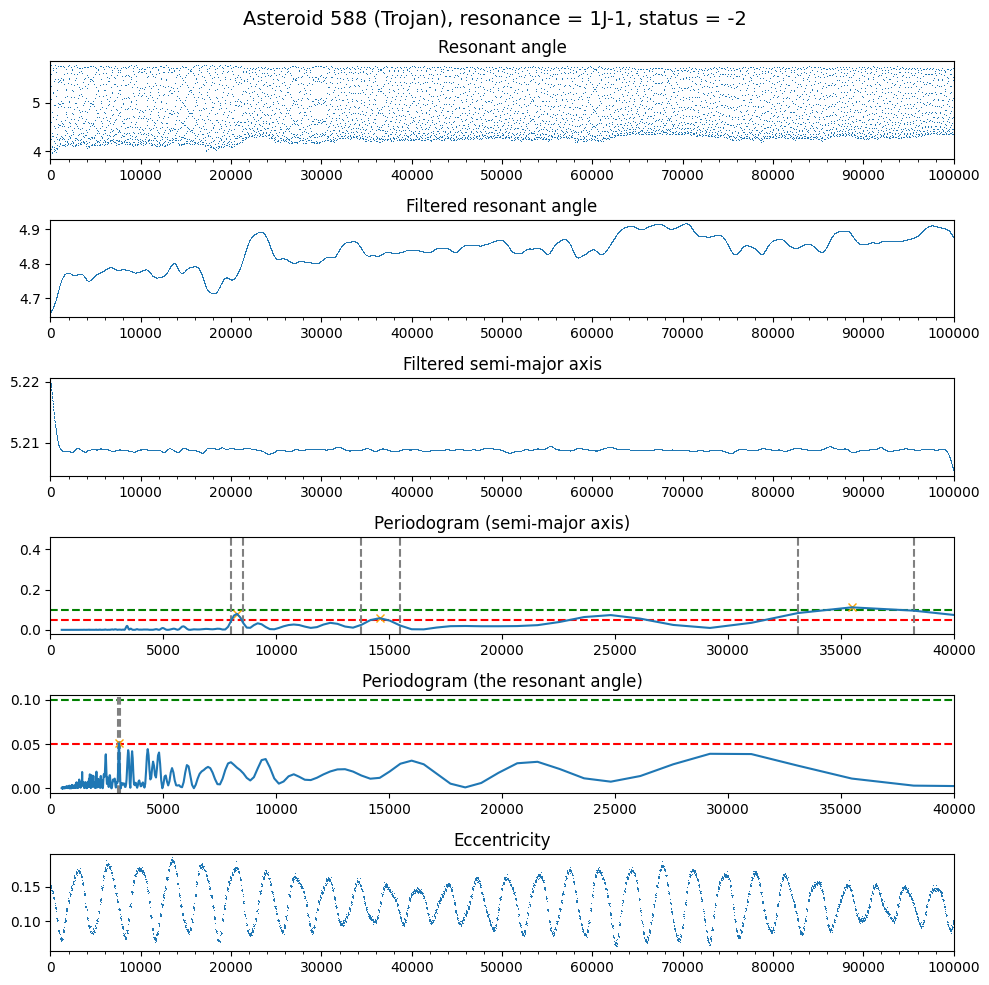

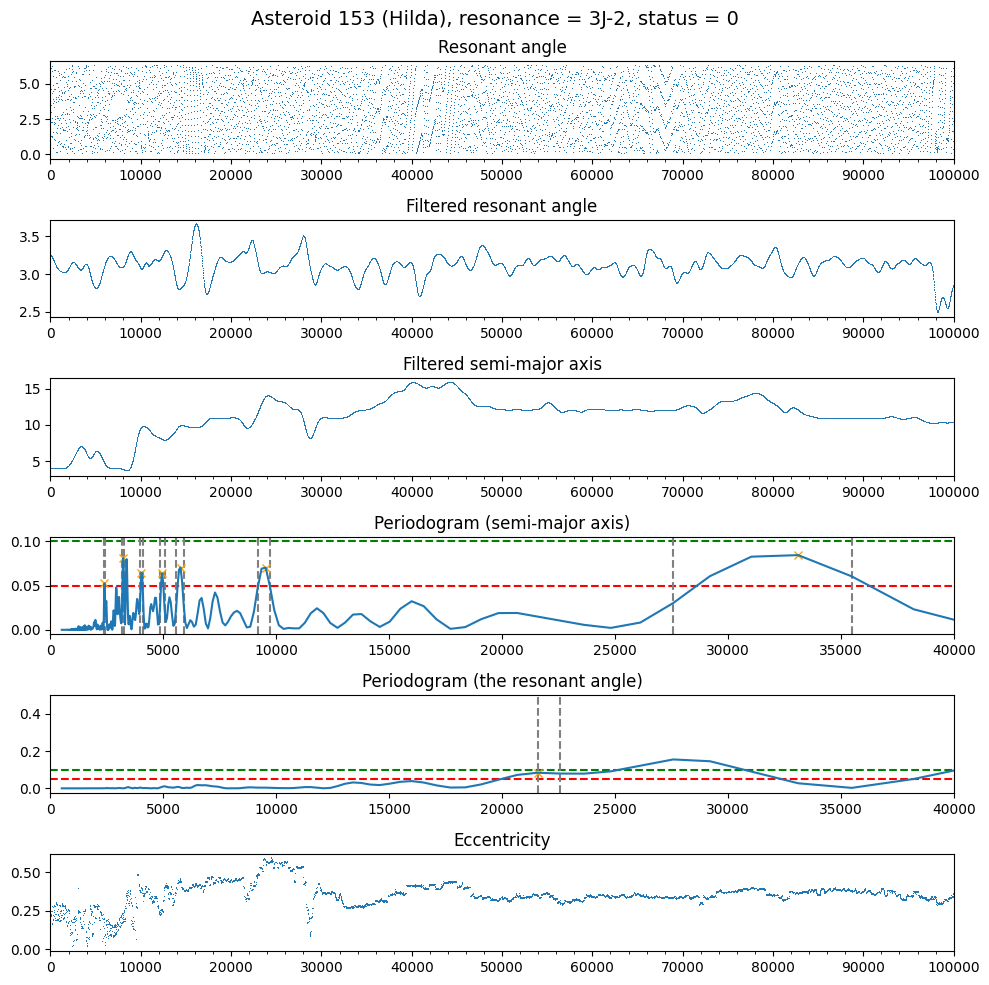

In [37]:
from resonances.experiment import loader

sim = loader.create_simulation_from_json('examples/asteroids.json')
sim.run()